In [149]:
# /// script
# dependencies = [
# "scipy",
# "numpy",
# "matplotlib",
# "pandas",
# "openpyxl",
# "nptyping",
# ]
# ///
# AS PER PYTHON STYLE GUIDES FOR REQUIRED PACKAGES ^

import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from copy import deepcopy
from nptyping import NDArray

# Specific fxns, ect.
from scipy.stats import linregress
from matplotlib.lines import Line2D

In [130]:
# KNOWN DATA -- UPDATE AS NEEDED

RPMS = [400, 900, 1600, 2500]

class Electrolyte():
    """
    Wrapper class for electrolyte data
    """

    def __init__(self, conc, kin_visc, t_p, DAT) -> None:
        self.conc = conc # MOLAR
        self.kin_visc = kin_visc # CM^2 / S
        self.t_p = t_p # UNITLESS
        self.data = {}

        if isinstance(DAT, str):
            for i in range(4):
                self.data[RPMS[i]] = pd.read_excel(DAT, i)

        else:
            self.data = DAT

# Initialize electrolyte data

E1 = Electrolyte(1, 0.025, 0.36, "Electrolyte1_RDE_data.xlsx")
E2 = Electrolyte(4, 0.1, 0.55, "Electrolyte2_RDE_data.xlsx")
E3 = Electrolyte(1, 0.2, 0.25, "Electrolyte3_RDE_data.xlsx")

data = [E1, E2, E3]
E1.data[400].head()


,V (mV),Current Density (mA/cm2)
0,0.000000,5.781907
1,1.101101,5.554195
2,2.202202,5.596112
3,3.303303,5.745230
4,4.404404,5.652301


## 1a

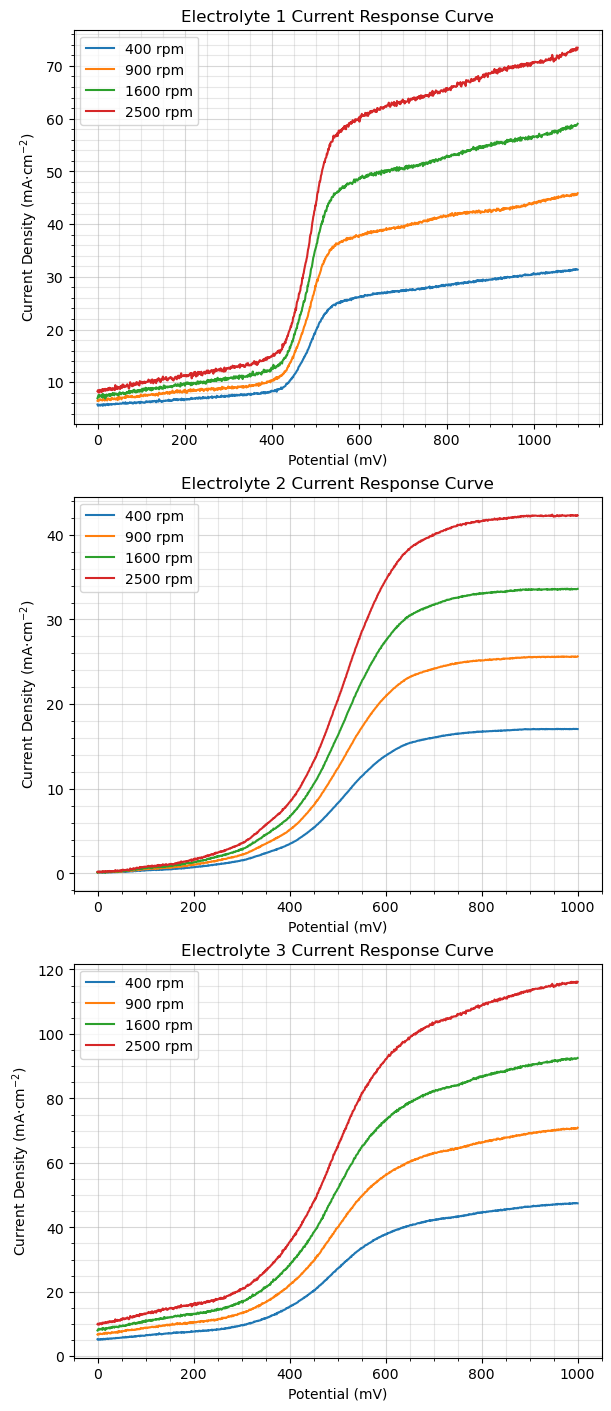

In [131]:
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(6,14))

for idx, ax in enumerate(axes):
    electrolyte = data[idx]
    ax.set_title(f'Electrolyte {idx+1} Current Response Curve')
    for rpm in electrolyte.data.keys():
        ax.plot(electrolyte.data[rpm]['V (mV)'], electrolyte.data[rpm]['Current Density (mA/cm2)'], label=f'{rpm} rpm')
    ax.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
    ax.set_xlabel("Potential (mV)")
    ax.minorticks_on()
    ax.grid(which='both', alpha=0.3)
    ax.grid(which='major', alpha=0.5)
    ax.legend()

## 1b

In [132]:
def linfit_range(data, minV, maxV):

    data_in_range = data[data['V (mV)'].between(minV, maxV)]

    voltages = data_in_range['V (mV)']
    currents = data_in_range['Current Density (mA/cm2)']

    return linregress(voltages, currents)
    

## 1c

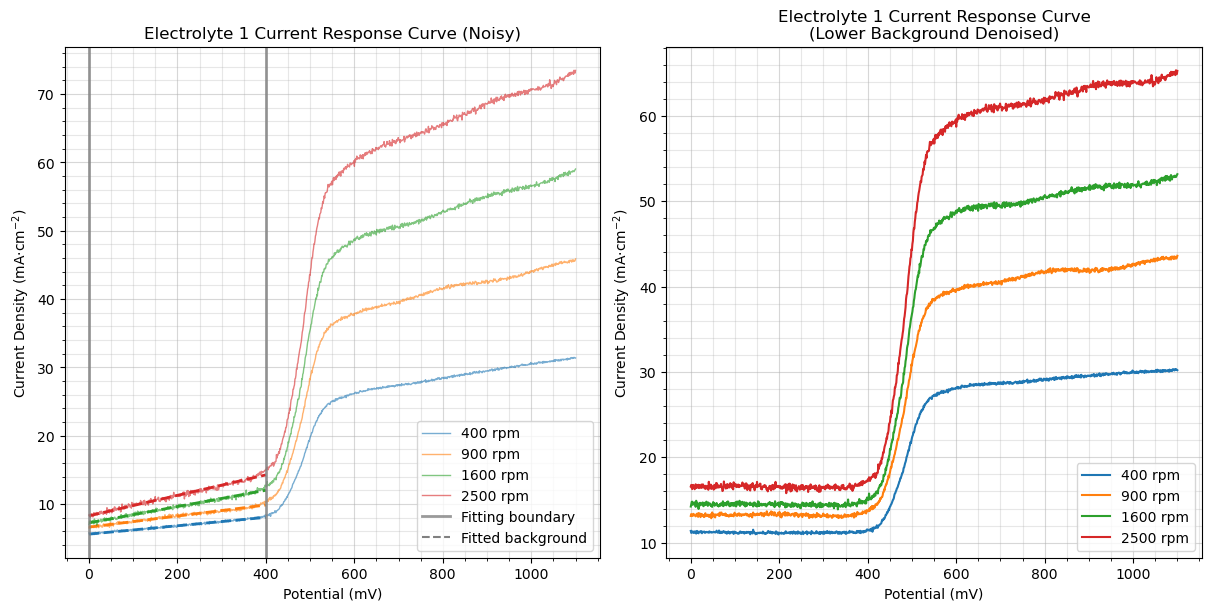

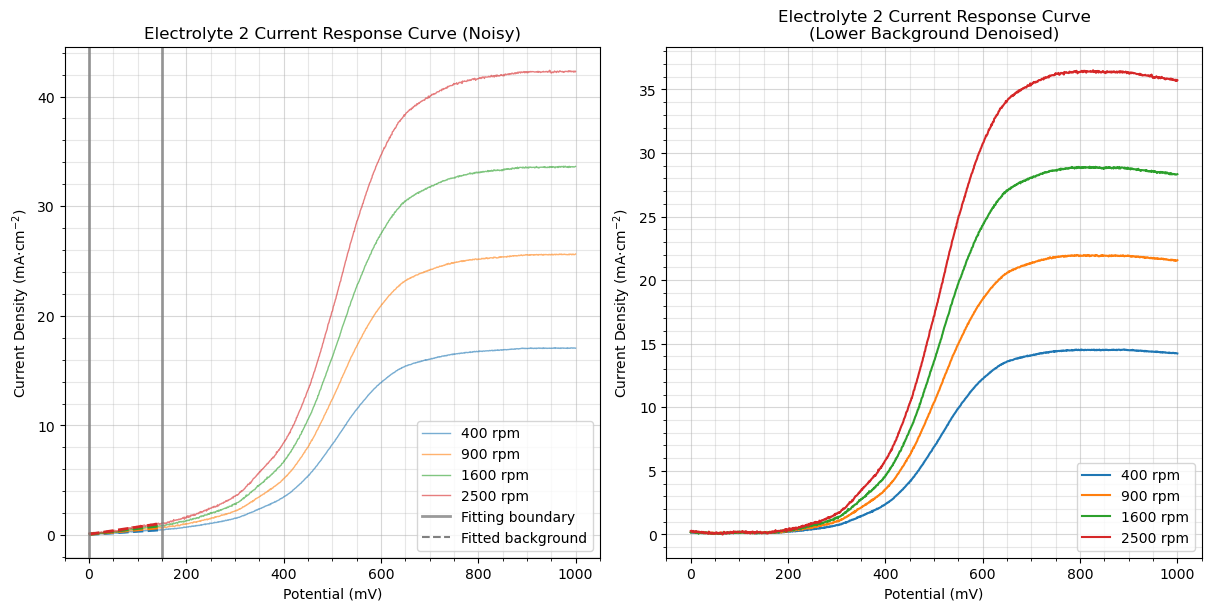

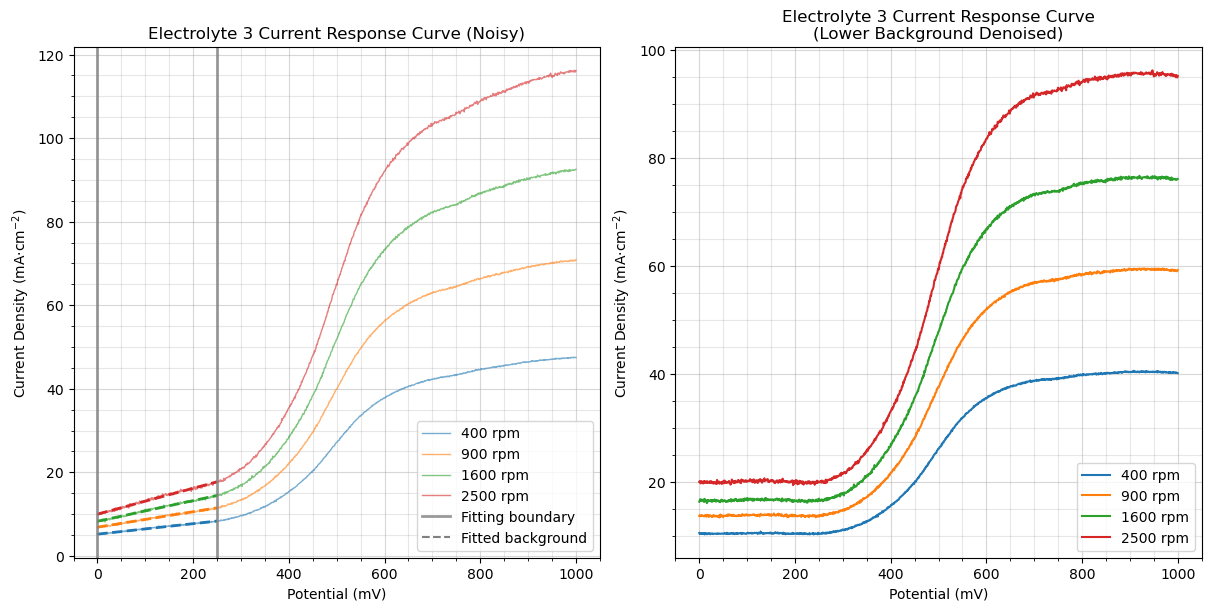

In [ ]:
# Subtract background

def subtract_bgnd(electrolyte, idx, minV, maxV, graph=True):
    if graph == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(12, 6))

    regressions = []
    for rpm in RPMS:
        data = electrolyte.data[rpm].copy(deep=True)

        regress = linfit_range(data, minV, maxV)
        regressions.append(regress)

        delta_fxn = lambda x, y: y - regress.slope*x + regress.intercept

        if graph == True:
            ax1.set_title(f'Electrolyte {idx} Current Response Curve (Noisy)')
            ax1.plot(data['V (mV)'], data['Current Density (mA/cm2)'], label=f'{rpm} rpm', alpha=0.6, linewidth=1)
            regress_range = np.linspace(minV, maxV, 1000)
            ax1.plot(regress_range, [regress.slope*x + regress.intercept for x in regress_range],
                     color=ax1.lines[-1].get_color(),
                     ls='--',
                     linewidth=2
                     )
            ax1.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
            ax1.set_xlabel("Potential (mV)")
            ax1.minorticks_on()
            ax1.grid(which='both', alpha=0.3)
            ax1.grid(which='major', alpha=0.5)

        # Change data and graph changed data
        data['Current Density (mA/cm2)'] = list(map(delta_fxn, data['V (mV)'], data['Current Density (mA/cm2)']))

        if graph == True:
            ax2.set_title(f'Electrolyte {idx} Current Response Curve\n(Lower Background Denoised)')
            ax2.plot(data['V (mV)'], data['Current Density (mA/cm2)'], label=f'{rpm} rpm')
            ax2.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
            ax2.set_xlabel("Potential (mV)")
            ax2.minorticks_on()
            ax2.grid(which='both', alpha=0.3)
            ax2.grid(which='major', alpha=0.5)
            ax2.legend(loc='lower right')

    if graph==True:
        ax1.axvline(minV, color="gray", label='Fitting boundary', alpha=0.8, linewidth=2)
        ax1.axvline(maxV, color="gray", alpha=0.8, linewidth=2)
        handles, labels = ax1.get_legend_handles_labels()
        handles.append(Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5))
        labels.append('Fitted background')
        ax1.legend(handles=handles, labels=labels)
        plt.show(fig)
    
    new_electrolyte = Electrolyte(
        electrolyte.conc,
        electrolyte.kin_visc,
        electrolyte.t_p,
        
    )

    return regressions

E1_lowerfit = subtract_bgnd(E1, 1, 0, 400)
E2_lowerfit = subtract_bgnd(E2, 2, 0, 150)
E3_lowerfit = subtract_bgnd(E3, 3, 0, 250)

## 1d

AttributeError: 'list' object has no attribute 'data'

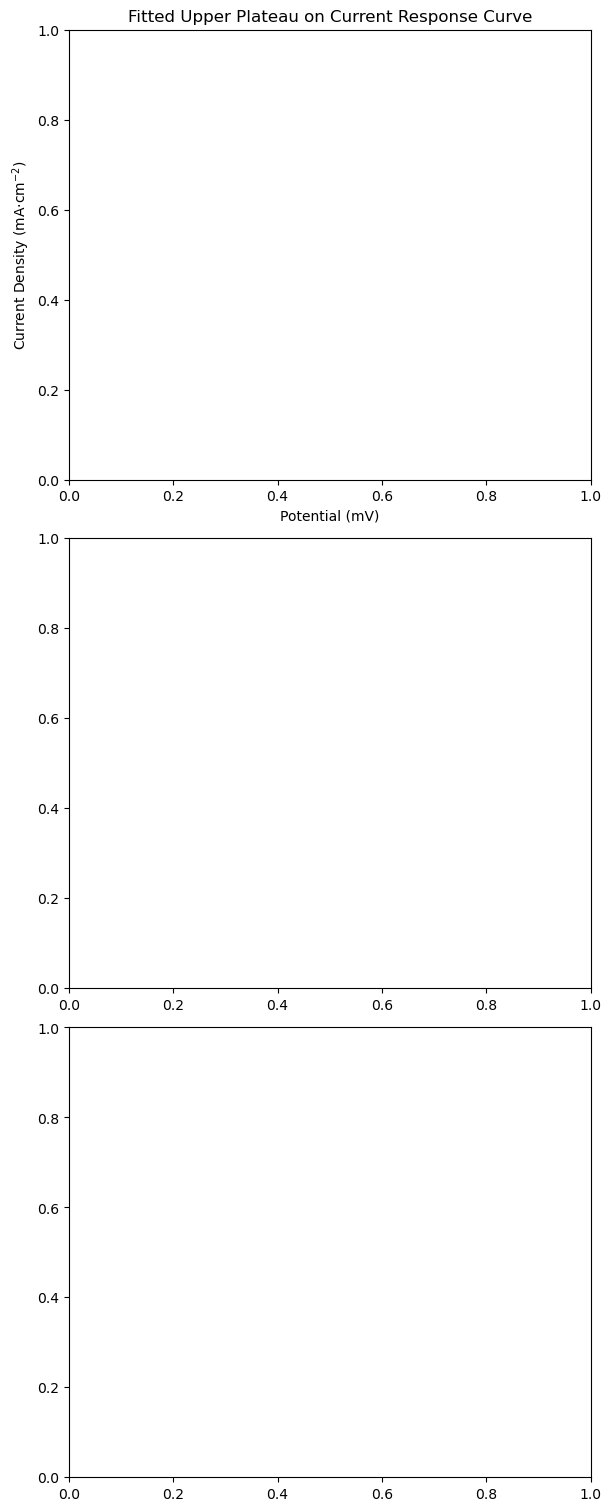

In [162]:
E1_base = subtract_bgnd(E1, 1, 0, 400, graph=False)
E2_base = subtract_bgnd(E2, 2, 0, 150, graph=False)
E3_base = subtract_bgnd(E3, 3, 0, 250, graph=False)

corrected_data = [E1_base, E2_base, E3_base]

start_end = [
    (650, 1100),
    (800, 900),
    (800, 925)
]

fitted_uppers = []

fig, axes = plt.subplots(3, 1, figsize=(6, 15), layout='constrained')
for i, e in enumerate(corrected_data):
    # Find upper bound
    axes[i].set_title(f'Fitted Upper Plateau on Current Response Curve')
    axes[i].set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
    axes[i].set_xlabel("Potential (mV)")
    cdata = corrected_data[i].data
    start = start_end[idx][0]
    end = start_end[i][1]
    upper_fit = linfit_range(e, start, end)
    fitted_uppers.append(upper_fit)
    axes[i].plot(cdata['V (mV)'], cdata['Current Density (mA/cm2)'])
    N = np.linspace(start, end, 1000)
    axes[i].axvline(start, color='black')
    axes[i].axvline(end, color='black')
    axes[i].plot(N, [upper_fit.slope*n + upper_fit.intercept for n in N], label=r'Fitted upper plateau')
    axes[i].minorticks_on()
    axes[i].grid(which='both', alpha=0.3)
    axes[i].grid(which='major', alpha=0.5)
    axes[i].legend()


## 1e

INFLECTION POINTS
------------------------
[479.12605106215403, 515.1981932469408, 501.2464864723019]


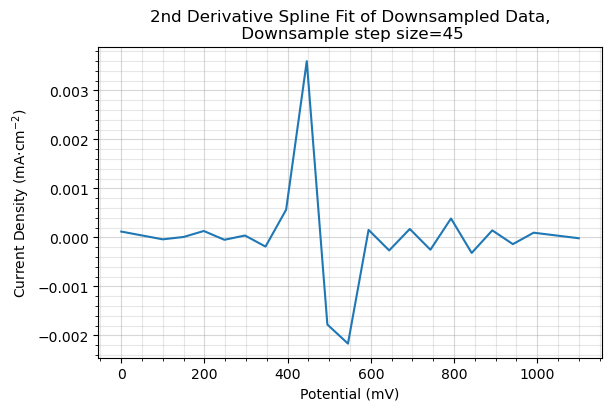

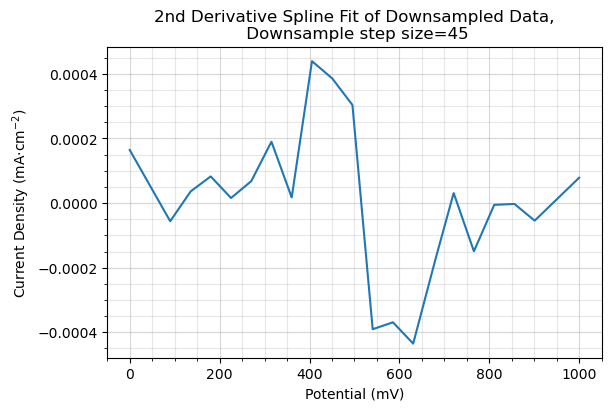

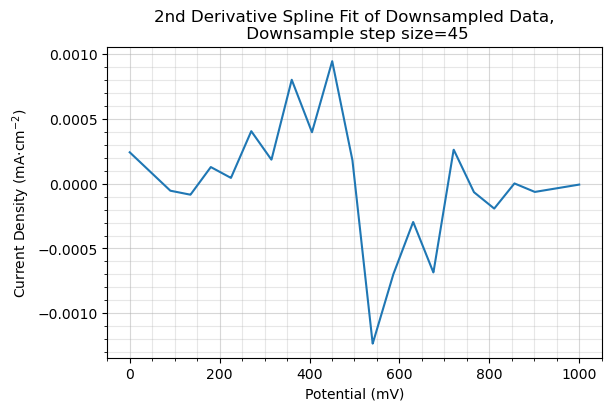

In [111]:
from scipy.optimize import newton

def pt_inflec(electrolyte, guess):
    x_reduced = electrolyte.data['V (mV)'][::45]
    y_reduced = electrolyte.data['Current Density (mA/cm2)'][::45]

    spline_dxdx = sp.interpolate.make_interp_spline(x_reduced, y_reduced).derivative().derivative()

    # Plot
    fig, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(6, 4))
    ax1.set_title(f'2nd Derivative Spline Fit of Downsampled Data,\n Downsample step size=45')

    N = np.linspace(0, max(electrolyte.data['V (mV)']), 3000)
    ax1.plot(N, [spline_dxdx(n) for n in N])
    

    ax1.set_ylabel(r"Current Density (mA$\cdot$cm$^{-2}$)")
    ax1.set_xlabel("Potential (mV)")
    ax1.minorticks_on()
    ax1.grid(which='both', alpha=0.3)
    ax1.grid(which='major', alpha=0.5)
    
    # Predict zero
    return newton(spline_dxdx, guess)

guesses = [475, 510, 500]
print("INFLECTION POINTS\n------------------------")
inflec_pts = []
for i, e in enumerate(corrected_data):
    inflec_pts.append(pt_inflec(e, guesses[i]))
print(inflec_pts)



## 1f

In [ ]:
def calc_IL(basefit, endfit, inflec) -> float:
    lower_at_inflec = basefit.slope*inflec + basefit.intercept
    upper_at_inflec = endfit.slope*inflec + endfit.intercept

    I_F = upper_at_inflec - lower_at_inflec

    return I_F

ILS = []
minV = [0, 0, 0]
maxV = [400, 150, 250]
for i in range(3):
    ILS.append(
        calc_IL(
        linfit_range(data[i], minV[i], maxV[i]),
        fitted_uppers[i],
        inflec_pts[i]
        )
    )

# Graph I_L as a function of angular velocity

fig, ax = plt.subplots(layout='constrained')

ax.set_title(r"$i_L$ vs. $\omega$")

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.plot(x, y, ls='', marker='.')

#ax.set_xlim(1979, 2024)
#ax.set_ylim(1.8, 2.1)
ax.minorticks_on()
ax.grid(which='both', alpha=0.3)
ax.grid(which='major', alpha=0.5)
ax.legend(loc='best')

[19.248953996059235, 12.959989383813745, 26.79934546355137]
